In [1]:
from model import VggBackgroundPretrained
import torch
from scipy.ndimage import median_filter
import numpy as np
from PIL import Image
from torchvision import transforms

width = 320
height = 240
n_class = 3

net = VggBackgroundPretrained(n_class=n_class, width=width, height=height)
load_path = "./vgg-background-weights_fine_tuning.pth"

load_weights = torch.load(load_path, map_location={'cuda:0': 'cpu'})
net.load_state_dict(load_weights)
print("load success")

load success


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

path = "../../dataset/val/0/car_744.jpg"
image = Image.open(path).convert("RGB")
image = image.resize((width, height))

inputs = transform(image)
inputs = inputs.view(1, 3, height, width)

In [3]:
output = net(inputs)
target = torch.FloatTensor(1, output.shape[-1])
target[0, :] = 1
net.zero_grad()
output.backward(gradient=target)
grad = net.grad_in.cpu().data.numpy()
saliency_maps = median_filter(np.max(np.abs(grad[0]), axis=0), 3)


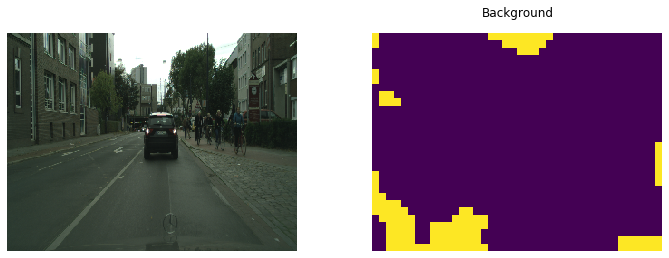

In [5]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(1, 2, 1)

image = Image.open(path).convert("RGB")
image = image.resize((width, height))
ax.imshow(np.asarray(image))
ax.axis('off')

ax = f.add_subplot(1, 2, 2)
thr = np.sort(saliency_maps.ravel())[int(0.1 * 30 * 40)]
ax.matshow(saliency_maps < thr)
ax.set_title('Background')
ax.axis('off')

plt.show()